In [1]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import time
import warnings
warnings.filterwarnings("ignore")

import torch
random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [2]:
from exp.data import load_image_dataset, load_tabular_dataset

dataset_name = 'MNIST'

X_train, X_test, Y_train, Y_test, _, _ = load_image_dataset(dataset_name, './data/')

In [3]:
X_train = X_train.reshape(-1,1,28,28)
X_test = X_test.reshape(-1,1,28,28)
Y_train = torch.nn.functional.one_hot(torch.tensor(Y_train)).numpy()
Y_test = torch.nn.functional.one_hot(torch.tensor(Y_test)).numpy()

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl

class DataModule(pl.LightningDataModule):
    def __init__(self, batch_size, X_train, Y_train, X_test, Y_test):
        self.batch_size = batch_size
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test

    def train_dataloader(self):
        train_dataset = TensorDataset(torch.tensor(self.X_train).float(),torch.tensor(self.Y_train,dtype=torch.long).float())
        return DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True) 

    def val_dataloader(self):
        print(self.X_test.shape)
        print(self.Y_test.shape)
        val_dataset = TensorDataset(torch.tensor(self.X_test).float(),torch.tensor(self.Y_test,dtype=torch.long).float())
        return DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False) 

class Lit_CNN_Network(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.out = nn.Linear(32 * 7 * 7, 10)
        self.loss = nn.CrossEntropyLoss()
        self.example_input_array = torch.randn([1,1,28,28])

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        return torch.sigmoid(self.out(x))
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.forward(x)
        loss = self.loss(y_pred, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.forward(x)
        loss = self.loss(y_pred, y)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [17]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger

net = Lit_CNN_Network()
BATCH_SIZE = 1024
dm = DataModule(BATCH_SIZE, X_train, Y_train, X_test, Y_test)
bar = TQDMProgressBar(refresh_rate=20)
es = EarlyStopping(monitor="val_loss", mode="min", patience=5)
logger = TensorBoardLogger("lightning_logs", name="MNIST_model", version=0, log_graph=True)
trainer = pl.Trainer(callbacks=[bar, es], 
                     max_epochs=100, 
                     log_every_n_steps=10, 
                     logger=logger, 
                     enable_checkpointing=False)

trainer.fit(net, dm)
#trainer.save_checkpoint("MNIST_black_box.ckpt")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type             | Params | In sizes        | Out sizes      
-------------------------------------------------------------------------------
0 | conv1 | Sequential       | 416    | [1, 1, 28, 28]  | [1, 16, 14, 14]
1 | conv2 | Sequential       | 12.8 K | [1, 16, 14, 14] | [1, 32, 7, 7]  
2 | out   | Linear           | 15.7 K | [1, 1568]       | [1, 10]        
3 | loss  | CrossEntropyLoss | 0      | ?               | ?              
-------------------------------------------------------------------------------
28.9 K    Trainable params
0         Non-trainable params
28.9 K    Total params
0.116     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s](10000, 1, 28, 28)
(10000, 10)
                                                              

/Users/francescobodria/anaconda3/envs/latent_space/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/francescobodria/anaconda3/envs/latent_space/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 42: 100%|██████████| 69/69 [00:42<00:00,  1.64it/s, loss=1.47, v_num=0]


In [5]:
net = Lit_CNN_Network()
net.eval()
net = net.load_from_checkpoint(checkpoint_path="MNIST_black_box.ckpt")

In [6]:
from sklearn.metrics import accuracy_score

print(accuracy_score(np.argmax(net(torch.tensor(X_train).float()).detach().numpy(),axis=1),np.argmax(Y_train,axis=1)))
print(accuracy_score(np.argmax(net(torch.tensor(X_test).float()).detach().numpy(),axis=1),np.argmax(Y_test,axis=1)))

0.9922833333333333
0.9901


In [7]:
def predict(x, return_proba=False):
    if len(x.shape)==2:
        x = x.reshape(-1,1,28,28)
    elif len(x.shape)==3:
        x = x.reshape(-1,1,28,28)
    net.eval()
    if return_proba:
        return net(torch.tensor(x).float()).detach().numpy()
    else: return np.argmax(net(torch.tensor(x).float()).detach().numpy(),axis=1).astype(int).ravel()

y_test_pred = predict(X_test, return_proba=True)
y_train_pred = predict(X_train, return_proba=True)

In [8]:
X_train = np.hstack((X_train.reshape(-1,28*28),y_train_pred))
X_test = np.hstack((X_test.reshape(-1,28*28),y_test_pred))

In [34]:
latent_dim = 2
batch_size = 256
sigma = 4
max_epochs = 1000
early_stopping = 3
learning_rate = 1e-3

similarity_KLD = torch.nn.KLDivLoss(reduction='batchmean')

def compute_similarity(X, sigma, alpha=1):
    D_features = torch.cdist(X[:,:-10],X[:,:-10])
    D_class = torch.cdist(X[:,-10:],X[:,-10:])
    D = D_features + alpha * D_class
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)

def loss_function(X, Z, sigma=1):
    Sx = compute_similarity(X, sigma)
    Sz = compute_similarity(Z, 1)
    loss = similarity_KLD(torch.log(Sx), Sz)
    return loss

class LinearModel(nn.Module):
    def __init__(self, input_shape, latent_dim=2):
        super(LinearModel, self).__init__()

        # encoding components
        self.fc1 = nn.Linear(input_shape, latent_dim)

    def encode(self, x):
        x = self.fc1(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return z

# Create Model
model = LinearModel(X_train.shape[1], latent_dim=latent_dim)

In [35]:
train_dataset = TensorDataset(torch.tensor(X_train).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataset = TensorDataset(torch.tensor(X_test).float())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

def check_and_clear(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    else:
        os.system('rm -r ' + dir_name)
        os.mkdir(dir_name)

check_and_clear('./models/weights')

model_params = list(model.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)

# record training process
epoch_train_losses = []
epoch_test_losses = []

#validation parameters
epoch = 1
best = np.inf

# progress bar
pbar = tqdm(bar_format="{postfix[0]} {postfix[1][value]:03d} {postfix[2]} {postfix[3][value]:.5f} {postfix[4]} {postfix[5][value]:.5f} {postfix[6]} {postfix[7][value]:d}",
            postfix=["Epoch:", {'value':0}, "Train Sim Loss", {'value':0}, "Test Sim Loss", {'value':0}, "Early Stopping", {"value":0}])

# start training
while epoch <= max_epochs:

    # ------- TRAIN ------- #
    # set model as training mode
    model.train()
    batch_loss = []

    for batch, (X_batch,) in enumerate(train_loader):
        optimizer.zero_grad()
        Z_batch = model(X_batch)  #
        loss  = loss_function(X_batch, Z_batch, sigma) 
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())

    # save result
    epoch_train_losses.append(np.mean(batch_loss))
    pbar.postfix[3]["value"] = np.mean(batch_loss)

    # -------- VALIDATION --------

    # set model as testing mode
    model.eval()
    batch_loss = []

    with torch.no_grad():
        for batch, (X_batch,) in enumerate(test_loader):
            Z_batch = model(X_batch)
            loss = loss_function(X_batch, Z_batch, sigma)
            batch_loss.append(loss.item())

    # save information
    epoch_test_losses.append(np.mean(batch_loss))
    pbar.postfix[5]["value"] = np.mean(batch_loss)
    pbar.postfix[1]["value"] = epoch

    if epoch_test_losses[-1] < best:
        wait = 0
        best = epoch_test_losses[-1]
        best_epoch = epoch
        torch.save(model.state_dict(), f'./models/weights/LinearTransparent.pt')
    else:
        wait += 1
    pbar.postfix[7]["value"] = wait
    if wait == early_stopping:
        break    
    epoch += 1
    pbar.update()

model.load_state_dict(torch.load(f'./models/weights/LinearTransparent.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

torch.save(model.state_dict(), f'./models/MNIST_{latent_dim}.pt')

Epoch: 000 Train Sim Loss 0.00000 Test Sim Loss 0.00000 Early Stopping 0

In [36]:
model.load_state_dict(torch.load(f'./models/MNIST_{latent_dim}.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

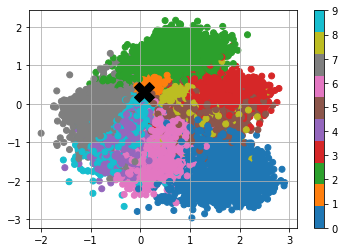

In [37]:
idx = 2
plt.scatter(Z_train[:,0],Z_train[:,1],c=np.argmax(y_train_pred,axis=1),cmap='tab10')
plt.plot(Z_test[idx,0],Z_test[idx,1],'kX',markersize=20)
plt.colorbar()
plt.grid(True)

In [41]:
idx = 2
pred = np.argmax(predict(X_test[idx:idx+1,:-10], return_proba=True))
pred

1

In [43]:
y_contrib = model.fc1.weight[:,-10:].detach().numpy()
y_contrib

array([[ 0.36061326, -0.0878802 , -0.17428079,  0.19382901, -0.14141314,
        -0.00148826, -0.06055902, -0.4208743 ,  0.08774716, -0.08426017],
       [-0.54898554,  0.15314876,  0.8732812 ,  0.00954962, -0.19375813,
        -0.06132353, -0.38182083,  0.1237724 ,  0.00497548, -0.10358167]],
      dtype=float32)

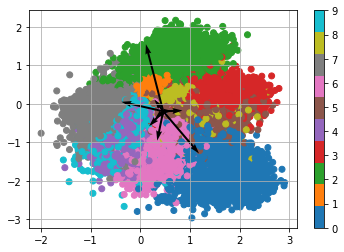

In [76]:
plt.scatter(Z_train[:,0],Z_train[:,1],c=np.argmax(y_train_pred,axis=1),cmap='tab10')
plt.colorbar()
c = np.mean(Z_train,axis=0)
for i in range(10):
    plt.quiver(c[0],c[1],y_contrib[0,i]*2,y_contrib[1,i]*2,angles='xy', scale_units='xy', scale=1, color='k')
plt.grid()

# Growing Spheres

In [21]:
from growingspheres import counterfactuals as cf

idx = 0
q = X_test[idx].copy().reshape(-1,28*28)
pred = int(predict(q))
pred

7

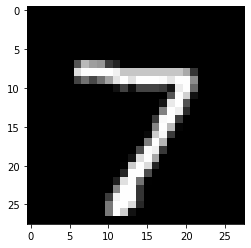

In [22]:
plt.imshow(q.reshape(28,28),cmap='gray')

In [27]:
CF = cf.CounterfactualExplanation(q, predict, method='GS', target_class=8)
CF.fit(n_in_layer=2000, first_radius=10, dicrease_radius=10, sparse=True, verbose=True)
q_cf_GS = CF.enemy

0 ennemies found in initial sphere. Zooming in...
Exploring...
Final number of iterations:  9
Final radius:  (15.400000000000002, 17.200000000000003)
Final number of ennemies:  8
Feature selection...
Reduced 727 coordinates


In [28]:
predict(q_cf_GS.reshape(1,-1))

array([8])

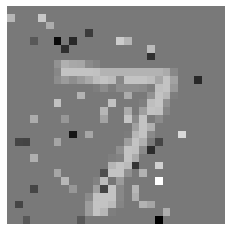

In [29]:
plt.imshow(q_cf_GS.reshape(28,28),cmap='gray')
plt.axis(False);

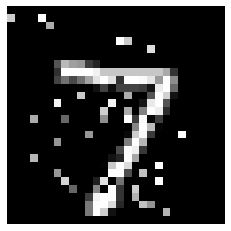

In [30]:
plt.imshow(np.clip(q_cf_GS,0,1).reshape(28,28),cmap='gray')
plt.axis(False);

In [46]:
from scipy.spatial.distance import cdist,euclidean

print('dis_dist:', euclidean(q_cf_GS,q))
print('dis_count:', np.mean(q_cf_GS!=q))
print('impl:',np.min(cdist(q_cf_GS.reshape(1,-1),X_test.reshape(-1,28*28))))

dis_dist: 6.758667258464617
dis_count: 0.07270408163265306
impl: 6.758667258464617


In [ ]:
from tqdm.notebook import tqdm

gs_cf = []
for i in tqdm(range(100)):
    q = X_test[i].reshape(1,-1).copy()
    def predict(q):
        return neigh.predict(model(torch.tensor(q).float()).detach())
    pred = int(predict(q))
    if pred == 7:
        target_class = 9
    else:
        target_class = 7
    CF = cf.CounterfactualExplanation(q, predict, method='GS', target_class=target_class)
    CF.fit(n_in_layer=2000, first_radius=10, dicrease_radius=10, caps=[0,1], sparse=True, verbose=False)
    gs_cf.append(CF.enemy)
gs_cf = np.vstack(gs_cf)

In [ ]:
from scipy.spatial.distance import cdist,euclidean

print('dis_dist:',np.mean(np.diag(cdist(gs_cf,X_test[:100].copy()))))
print('dis_count:', np.mean(np.mean(gs_cf[:100]!=X_test[:100].copy(),axis=1)))
print('impl:',np.mean(np.min(cdist(gs_cf,X_test),axis=1)))